# Глубокое обучение. Лабораторная работа №1

Конфигурация нейронной сети:

1. Входной слой содержит `w x h` нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет 28x28).
2. Выходной слой содержит `k` нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – 10 классов).
3. Скрытый слой содержит `s` нейронов (параметр).
4. Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
5. В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
6. В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
7. Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
    - Размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти).
    - Скорость обучения - 0.1.
    - Количество скрытых нейронов `s` - 300.
    - Количество эпох – 20.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import struct
from array import array
from pathlib import Path
from time import time
%matplotlib inline

## Подготовка данных

В качестве входных данных используется датасет MNIST-784 в формате IDX с сайта https://www.kaggle.com/datasets/hojjatk/mnist-dataset

### Загрузка данных

Пример реализации загрузчика: https://www.kaggle.com/code/hojjatk/read-mnist-dataset

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            images[i] = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
input_path = Path("../dataset")
training_images_filepath = input_path / "train-images-idx3-ubyte/train-images-idx3-ubyte"
training_labels_filepath = input_path / "train-labels-idx1-ubyte/train-labels-idx1-ubyte"
test_images_filepath = input_path / "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_labels_filepath = input_path / "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"

loader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = loader.load_data()

### Визуальная верификация

Визуализация случайных 10 изображений в тренировочной выборке и 5 изображений в тестовой выборке

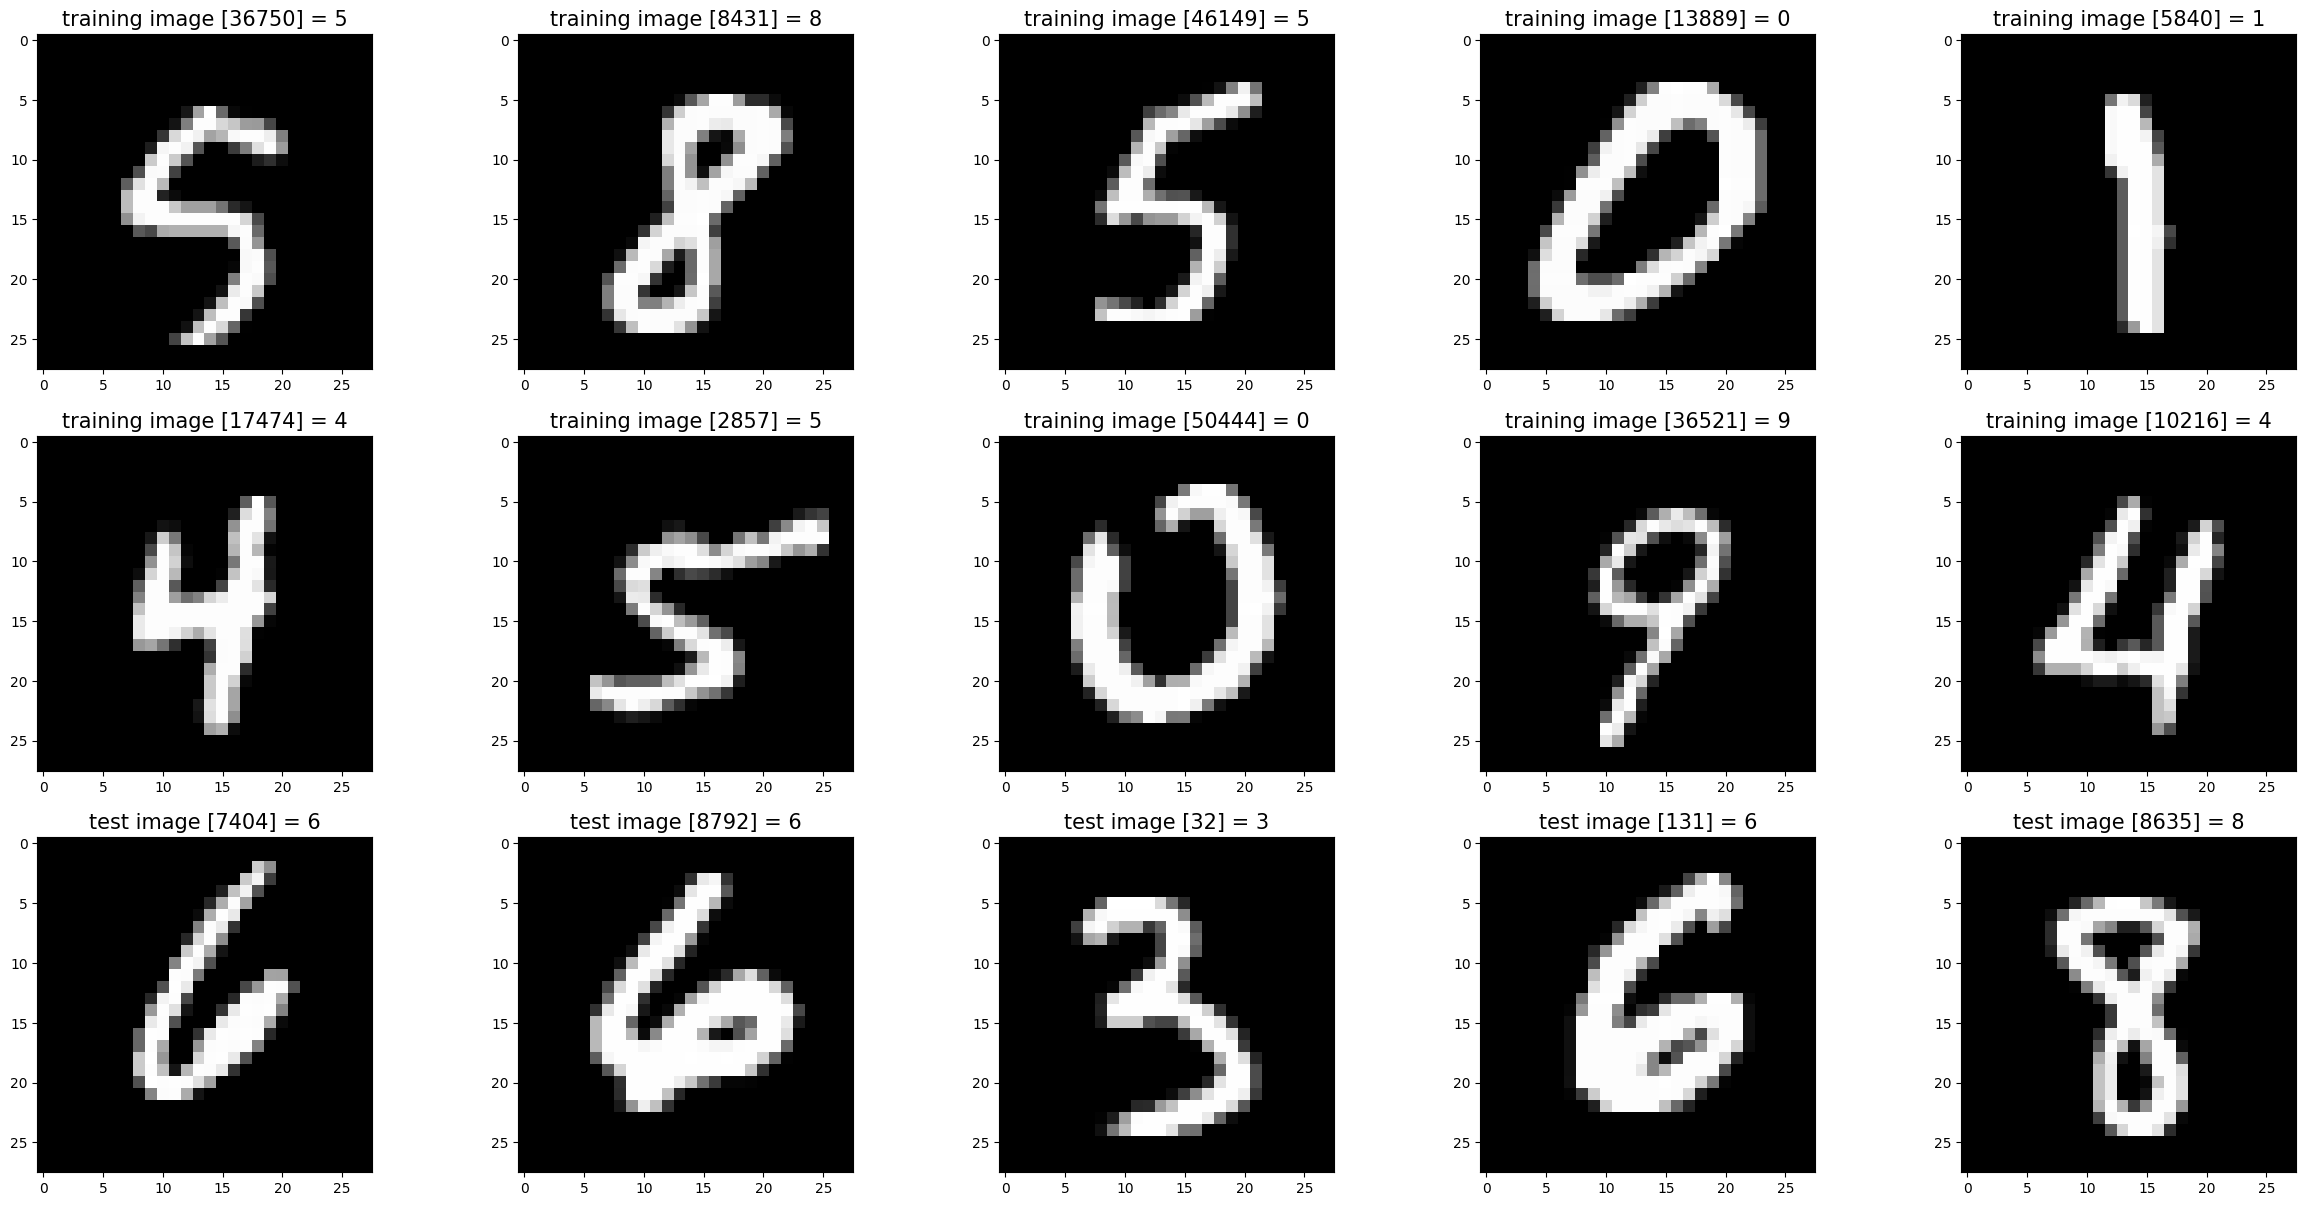

In [4]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for image, title_text in zip(images, title_texts):
        plt.subplot(rows, cols, index)
        plt.imshow(image.reshape(28, 28), cmap=getattr(plt.cm, "gray", None))
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)
        index += 1

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

### Нормализация данных

Конвертация данных в формат float64 и выполнение one-hot encoding для целевого признака.

In [5]:
def one_hot_encode(arr):
    classes = np.unique(arr)
    n_classes = len(classes)
    one_hot = np.zeros((arr.size, n_classes), dtype=np.float64)
    for index, value in enumerate(arr):
        class_index = np.where(classes == value)[0][0]
        one_hot[index, class_index] = 1.0
    return one_hot

X_train = np.array(X_train, dtype=np.float64) / 255.0
X_test = np.array(X_test, dtype=np.float64) / 255.0
y_train = one_hot_encode(np.array(y_train, dtype=int))
y_test = one_hot_encode(np.array(y_test, dtype=int))

print("Train shape: ", str(X_train.shape), str(y_train.shape))
print("Test shape: ", str(X_test.shape), str(y_test.shape))

Train shape:  (60000, 784) (60000, 10)
Test shape:  (10000, 784) (10000, 10)


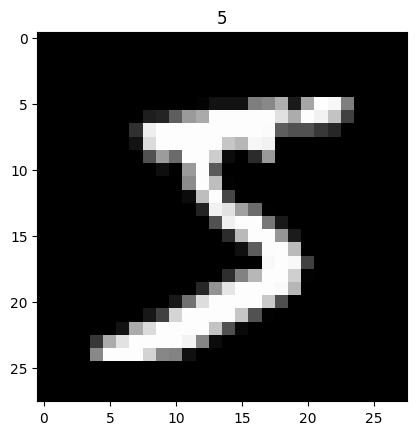

In [6]:
def show_image_norm(X, y, idx):
    img = X[idx].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(np.argmax(y[idx]))
    plt.show()
    
show_image_norm(X_train, y_train, 0)

## Реализация нейросети

### Инициализация параметров

Для сумматоров веса иницализируются случайными значениями, смещения иницализируются нулями.

In [7]:
def initialize_parameters(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * 0.01  # (784, 300)
    b1 = np.zeros((1, hidden_size))  # (1, 300)
    
    W2 = np.random.randn(hidden_size, output_size) * 0.01  # (300, 10)
    b2 = np.zeros((1, output_size))  # (1, 10)
    
    return W1, b1, W2, b2

Обновление параметров происходит с использованием градиентного спуска.

In [8]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

### Вспомогательные функции

Математические функции, используемые при реализации модели.

In [9]:
# ReLU activation function
def relu(Z):
    return np.maximum(0, Z)

# Derivative of ReLU
def relu_derivative(Z):
    return Z > 0

# Softmax activation function
def softmax(Z):
    return np.exp(Z) / np.exp(Z).sum(axis=1, keepdims=True)

# Cross-Entropy Loss
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

### Прямой проход

Реализация прямого прохода для одной "пачки данных" (batch).

In [10]:
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = X.dot(W1) + b1  # Hidden layer input
    A1 = relu(Z1)        # Hidden layer activation
    Z2 = A1.dot(W2) + b2 # Output layer input
    A2 = softmax(Z2)     # Output layer activation
    return Z1, A1, Z2, A2

### Обратный проход

Реализация обратного прохода для вычисления градиентов.

In [11]:
def backward_propagation(X, y_true, Z1, A1, Z2, A2, W2):
    m = y_true.shape[0]
    dZ2 = A2 - y_true               # dL_dZ2 (output layer gradient)
    # Z2.shape == (m, 10)
    dW2 = (A1.T).dot(dZ2) / m       # W2 gradient
    # W2.shape == (300, 10)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m  # b2 gradient
    # db2.shape == (1, 10)
    dA1 = dZ2.dot(W2.T)              # gradient x hidden layer
    # dA1.shape == (m, 300)
    dZ1 = dA1 * relu_derivative(Z1)  # dL_dZ1 (hidden layer gradient)
    # dZ1.shape == (m, 300)
    dW1 = (X.T).dot(dZ1) / m         # W1 gradient
    # dW1.shape == (784, 300)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m  # b1 gradient
    # db1.shape == (1, 300)
    return dW1, db1, dW2, db2

## Обучение модели

### Реализация обучения

В качестве функции ошибки используется кросс-энтропия.

In [12]:
def train(X_train, y_train, X_test, y_test, learning_rate, batch_size, epochs, input_size, hidden_size, output_size):
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    for epoch in range(epochs):
        # Случайное перемешивание тренировочных данных
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        start_time = time()

        # Обучение по "пачкам данных" (batches)
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)
            # Вывод ошибки раз в несколько итераций
            if i % 1000 == 0:
                loss = compute_loss(y_batch, A2)
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, Z2, A2, W2)
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        _, _, _, A2_train = forward_propagation(X_train, W1, b1, W2, b2)
        train_accuracy = np.mean(np.argmax(A2_train, axis=1) == np.argmax(y_train, axis=1))
        end_time = time()
        print(f"Epoch {epoch+1}: Elapsed {end_time - start_time:.2f} seconds.  Train accuracy: {train_accuracy:.4f}")

    _, _, _, A2_test = forward_propagation(X_test, W1, b1, W2, b2)
    test_accuracy = np.mean(np.argmax(A2_test, axis=1) == np.argmax(y_test, axis=1))
    print(f"Test accuracy: {test_accuracy:.4f}")

    return W1, b1, W2, b2

### Запуск тренировки

Параметры в текущем запуске:

* размер входного слоя - 784
* размер скрытого слоя - 300
* размер выходного слоя - 10
* скорость обучения - 0.1
* размер "пачки данных" (batch) - 32
* количество эпох - 20

In [13]:
input_size = 784  # 28x28 pixels
hidden_size = 300
output_size = 10
learning_rate = 0.1
batch_size = 32
epochs = 20

trained_params = train(X_train, y_train, X_test, y_test, learning_rate, batch_size, epochs, input_size, hidden_size, output_size)

Epoch 1: Elapsed 8.40 seconds.  Train accuracy: 0.9453
Epoch 2: Elapsed 8.45 seconds.  Train accuracy: 0.9649
Epoch 3: Elapsed 8.37 seconds.  Train accuracy: 0.9739
Epoch 4: Elapsed 7.74 seconds.  Train accuracy: 0.9808
Epoch 5: Elapsed 7.74 seconds.  Train accuracy: 0.9852
Epoch 6: Elapsed 8.09 seconds.  Train accuracy: 0.9883
Epoch 7: Elapsed 7.99 seconds.  Train accuracy: 0.9908
Epoch 8: Elapsed 7.82 seconds.  Train accuracy: 0.9913
Epoch 9: Elapsed 7.81 seconds.  Train accuracy: 0.9931
Epoch 10: Elapsed 8.18 seconds.  Train accuracy: 0.9947
Epoch 11: Elapsed 7.91 seconds.  Train accuracy: 0.9953
Epoch 12: Elapsed 7.84 seconds.  Train accuracy: 0.9970
Epoch 13: Elapsed 7.96 seconds.  Train accuracy: 0.9977
Epoch 14: Elapsed 7.80 seconds.  Train accuracy: 0.9982
Epoch 15: Elapsed 7.98 seconds.  Train accuracy: 0.9987
Epoch 16: Elapsed 7.80 seconds.  Train accuracy: 0.9988
Epoch 17: Elapsed 7.80 seconds.  Train accuracy: 0.9994
Epoch 18: Elapsed 7.84 seconds.  Train accuracy: 0.9997
E

### Результаты

Точность на тестовой выборке: более 99%

Точность на тренировочной выборке: более 98%